In [1]:
# %pip install gradio==3.47 --quiet
# %pip install clip_retrieval --quiet
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install diffusers --quiet
# %pip install accelerate --quiet

In [1]:
import warnings
warnings.filterwarnings('ignore')

import requests
import gradio as gr
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
import random
from peft import PeftModel
import numpy as np
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
# from clip_retrieval.clip_client import ClipClient, Modality
from diffusers import AutoencoderKL, UNet2DConditionModel, LCMScheduler, LMSDiscreteScheduler, AutoPipelineForText2Image

import base64
from base64 import b64encode

import io
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.express as px

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

np.set_printoptions(linewidth=200)

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
HF_ACCESS_TOKEN = "" # Add your HuggingFace access token

In [2]:
model_path = "segmind/tiny-sd"                          # Huggingface model path
imageHeight, imageWidth = 512, 512                                             # Image size
guidance_scale = 8                                                             # Guidance scale

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
scheduler = LMSDiscreteScheduler.from_pretrained(model_path, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet").to(torch_device)
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae").to(torch_device)

In [3]:
def get_text_embeddings(prompt, tokenizer=tokenizer, text_encoder=text_encoder, torch_device=torch_device, batch_size=1):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return text_embeddings

In [4]:
def generate_latents(seed, height=imageHeight, width=imageWidth, torch_device=torch_device, unet=unet, batch_size=1):
    generator = torch.Generator().manual_seed(int(seed))
    
    latents = torch.randn(
      (batch_size, unet.config.in_channels, height // 8, width // 8),
      generator=generator,
    ).to(torch_device)

    return latents

In [5]:
def generate_modified_latents(poke, seed, pokeX=None, pokeY=None, pokeHeight=None, pokeWidth=None, imageHeight=imageHeight, imageWidth=imageWidth):
    original_latents = generate_latents(seed, height=imageHeight, width=imageWidth)
    if poke:
        poke_latents = generate_latents(seed, height=pokeHeight, width=pokeWidth)

        x_origin = pokeX // 8 - poke_latents.shape[2] // 2          
        y_origin = pokeY // 8 - poke_latents.shape[3] // 2

        modified_latents = original_latents.clone()
        modified_latents[:,:,x_origin:x_origin+poke_latents.shape[2],y_origin:y_origin+poke_latents.shape[3]] = poke_latents
    else:
        modified_latents = None

    return original_latents, modified_latents

In [6]:
def convert_to_pil_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [7]:
def generate_images(latents, text_embeddings, num_inference_steps, unet=unet, guidance_scale=guidance_scale, vae=vae, scheduler=scheduler, intermediate=False):
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    images = []
    
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if intermediate:
            Latents = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(Latents).sample
            images.append(convert_to_pil_image(image))

    if not intermediate:
        Latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(Latents).sample
        images = convert_to_pil_image(image)

    return images

# Poking latent space

The objective is to understand how a poke at the initial noise influences the image generation of diffusion models.

In [8]:
def visualize_poke(pokeX, pokeY, pokeHeight, pokeWidth, imageHeight=imageHeight, imageWidth=imageWidth):
    if pokeX - pokeWidth // 2 < 0 or pokeX + pokeWidth // 2 > imageWidth or pokeY - pokeHeight // 2 < 0 or pokeY + pokeHeight // 2 > imageHeight:
        gr.Warning("Error: Poking region outside image")
    shape = [(pokeX - pokeWidth // 2, pokeY - pokeHeight // 2), (pokeX + pokeWidth // 2, pokeY + pokeHeight // 2)] 
    img = Image.new("RGB", (imageHeight, imageWidth))
    rec = ImageDraw.Draw(img) 
    rec.rectangle(shape, outline ="white") 
    return img

In [9]:
def display_images(prompt, seed, num_inference_steps, poke=False, pokeX=None, pokeY=None, heightPoke=None, widthPoke=None, intermediate=False):
    text_embeddings = get_text_embeddings(prompt)
    latents, modified_latents = generate_modified_latents(poke, seed, pokeX, pokeY, heightPoke, widthPoke)
    images = generate_images(latents, text_embeddings, num_inference_steps, intermediate=intermediate)

    if poke: modImages = generate_images(modified_latents, text_embeddings, num_inference_steps, intermediate=intermediate)
    else:    modImages = None
    
    return images, modImages

# Setting the parameters

In [12]:
prompt = "dog in car"
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

poke = True                         # Set true if you want to poke
intermediate = True                 # Set true if you want to see intermediate images
pokeX, pokeY = 256, 256             # Poke coordinates
pokeHeight, pokeWidth = 128, 128    # Poke size

In [13]:
if pokeX - pokeWidth // 2 < 0 or pokeX + pokeWidth // 2 > imageWidth or pokeY - pokeHeight // 2 < 0 or pokeY + pokeHeight // 2 > imageHeight:
    print("Error: Poking region outside image")

# Visualizing poke and the generated images

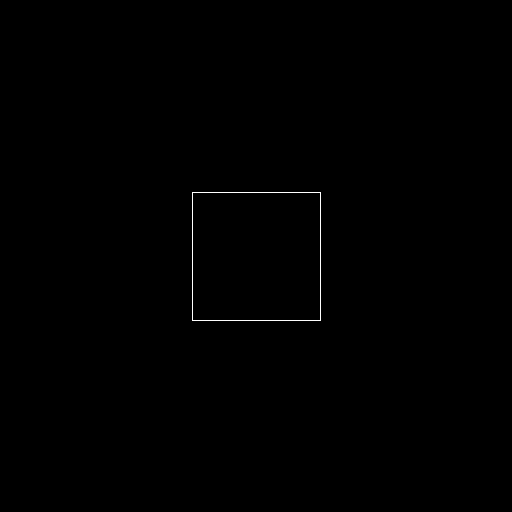

In [14]:
visualize_poke(pokeX, pokeY, pokeHeight, pokeWidth)

In [20]:
images, modImages = display_images(prompt, seed, num_inference_steps, poke, pokeX, pokeY, pokeHeight, pokeWidth, intermediate)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

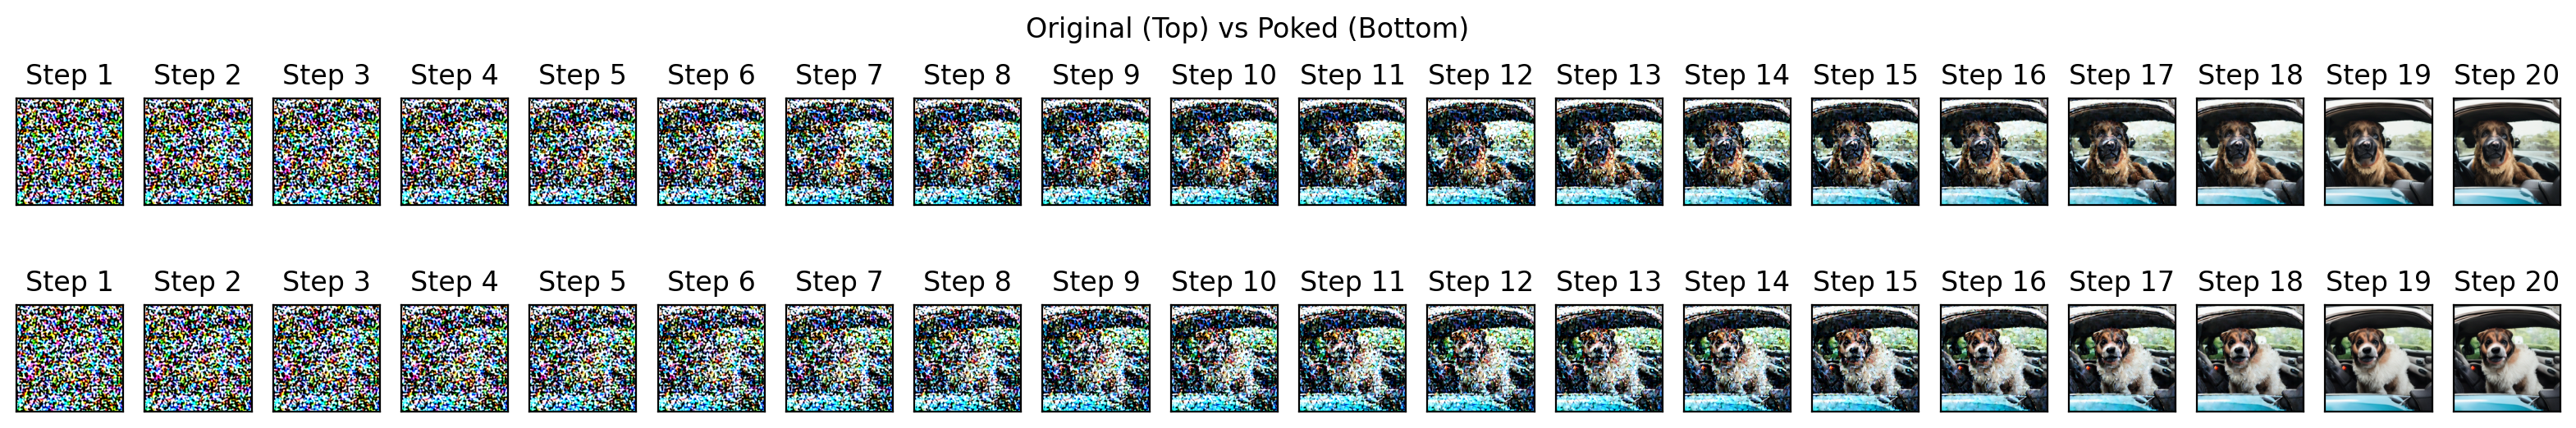

In [21]:
if poke:
    if intermediate:
        fig, ax = plt.subplots(2, num_inference_steps, dpi=200, figsize=(num_inference_steps, 3))
        fig.suptitle("Original (Top) vs Poked (Bottom)")

        for i in range(num_inference_steps):
            ax[0][i].set_title(f"Step {i+1}")
            ax[0][i].imshow(images[i])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticks([])

            ax[1][i].set_title(f"Step {i+1}")
            ax[1][i].imshow(modImages[i])
            ax[1][i].set_xticks([])
            ax[1][i].set_yticks([])

    else:
        fig, ax = plt.subplots(2, 1, dpi=200, figsize=(1, 2))
        fig.suptitle("Original (Top) vs Poked (Bottom)")
        ax[0].imshow(images)
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(modImages)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
else:
    if intermediate:    
        fig, ax = plt.subplots(1, num_inference_steps, dpi=200, figsize=(num_inference_steps, 2))
        fig.suptitle("Images")
        for i in range(num_inference_steps):
            ax[i].set_title(f"Step {i+1}")
            ax[i].imshow(images[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    else:
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2,2))
        fig.suptitle("Image")
        ax.imshow(images)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

# Prompt Interpolation

The objective is to understand the image generation in between two prompts 

In [23]:
def interpolate_prompts(promptA, promptB, num_interpolation_steps):
    text_embeddingsA = get_text_embeddings(promptA)
    text_embeddingsB = get_text_embeddings(promptB)

    interpolated_embeddings = []
    
    for i in range(num_interpolation_steps):
        alpha = i / num_interpolation_steps
        interpolated_embedding = torch.lerp(text_embeddingsA, text_embeddingsB, alpha)
        interpolated_embeddings.append(interpolated_embedding)

    return interpolated_embeddings

In [24]:
def display_prompt_images(seed, promptA, promptB, num_inference_steps, num_images):
    latents = generate_latents(seed)
    text_embeddings = interpolate_prompts(promptA, promptB, num_images)
    images = []
    for i in range(num_images):   
        image = generate_images(latents, text_embeddings[i], num_inference_steps)
        images.append((image,i+1))
        
    return images

In [18]:
promptA = "a car driving on a highway in a city"
promptB = "a truck driving on a highway in a city"

num_images = 5                      # Number of images to generate
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

In [19]:
images = display_prompt_images(seed, promptA, promptB, num_inference_steps, num_images)

100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


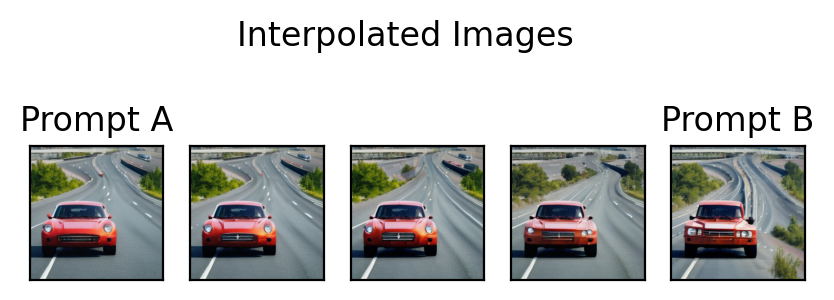

In [20]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Interpolated Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].set_title("Prompt A")
ax[num_images-1].set_title("Prompt B") 

plt.show()

# Multi Seed

In [53]:
def display_seed_images(prompt, num_inference_steps, num_images):
    text_embeddings = get_text_embeddings(prompt)

    images = []
    for i in range(num_images):   
        latents = generate_latents(i)
        image = generate_images(latents, text_embeddings, num_inference_steps)
        images.append((image,i+1))

    return images   

In [54]:
prompt = "red balloon in the sky"
num_images = 5                      # Number of images to generate
num_inference_steps = 5             # 20+ for good results
seed = 69420                        # Any integer

In [55]:
images = display_seed_images(prompt, num_inference_steps, num_images)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

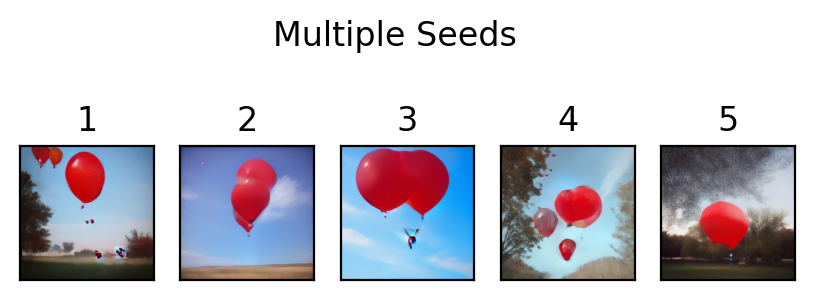

In [57]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Multiple Seeds")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_title(images[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

# Find images spread nearby

In [74]:
def display_spread_images(prompt, seed, num_inference_steps, num_images, differentiation):
    text_embeddings = get_text_embeddings(prompt)
    ilatent = generate_latents(seed)

    images = []
    for i in range(num_images):
        latent = ilatent + differentiation*generate_latents(seed + random.randint(0, 1000))
        image = generate_images(latent, text_embeddings, num_inference_steps)
        images.append((image,i+1))

    return images   

In [71]:
prompt = "red balloon in the sky"
num_images = 3                      # Number of images to generate
differentiation = 0.1               # Differentiation factor
num_inference_steps = 3             # 20+ for good results
seed = 69420                        # Any integer

In [72]:
images = display_spread_images(prompt, seed, num_inference_steps, num_images, differentiation)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

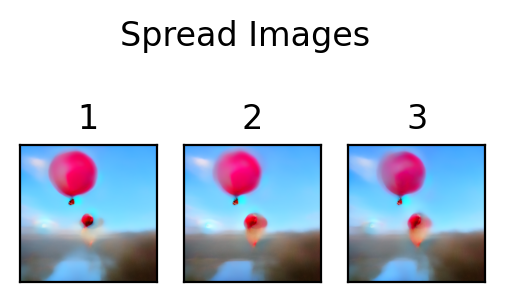

In [75]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Spread Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_title(images[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

# Find images in circular path

In [76]:
def display_circular_images(prompt, seed, num_inference_steps, num_images, differentiation):
    text_embeddings = get_text_embeddings(prompt)

    latents_x = generate_latents(seed)
    latents_y = generate_latents(seed*180)

    scale_x = torch.cos(torch.linspace(0, 1, 10)*2*torch.pi*differentiation).to(torch_device)
    scale_y = torch.sin(torch.linspace(0, 1, 10)*2*torch.pi*differentiation).to(torch_device)

    noise_x = torch.tensordot(scale_x, latents_x, dims=0)
    noise_y = torch.tensordot(scale_y, latents_y, dims=0)

    noise = noise_x + noise_y
    batched_noise = torch.split(noise, num_images)

    images = []
    for i in range(num_images):   
        image = generate_images(batched_noise[0][i], text_embeddings, num_inference_steps)
        images.append((image,i+1))

    return images   

In [14]:
prompt = "red balloon in the sky"
num_images = 5                      # Number of images to generate
differentiation = 0.1               # Differentiation factor
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

In [23]:
images = display_circular_images(prompt, seed, num_inference_steps, num_images, differentiation)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


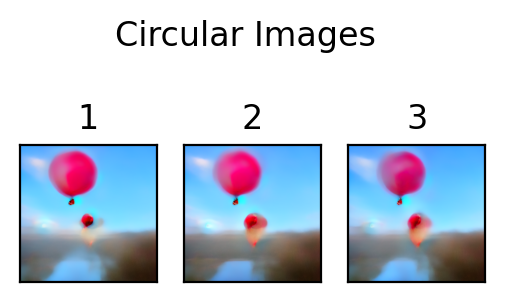

In [77]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Circular Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_title(images[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

# Peek into training dataset

In [25]:
prompt = "cat"        

In [26]:
def retrieve_images(prompt):
    client = ClipClient(
        url="https://knn.laion.ai/knn-service",
        indice_name="laion5B-L-14",
        aesthetic_score=9,
        aesthetic_weight=0.5,
        modality=Modality.IMAGE,
        num_images=10,
    )
    results = client.query(text=prompt)
    image_captions = []
    for result in results:
        caption, url = result["caption"], result["url"]
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content))
            image_captions.append((image, caption))
        except:
            pass
    return image_captions

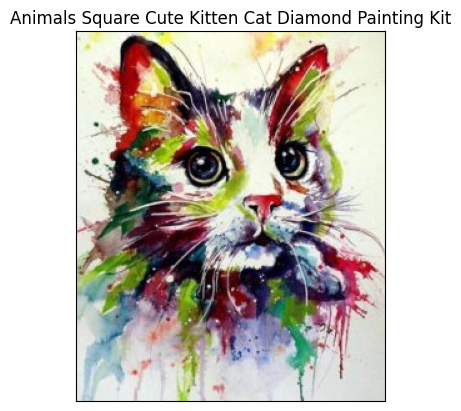

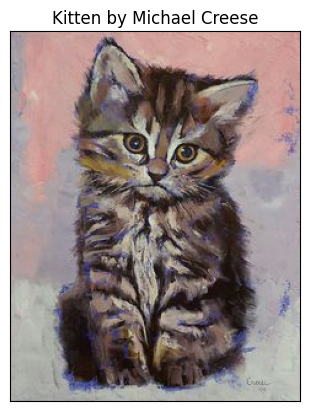

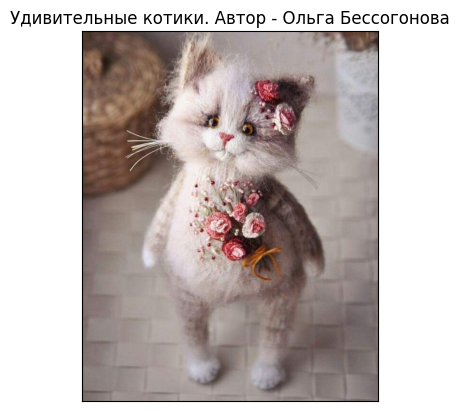

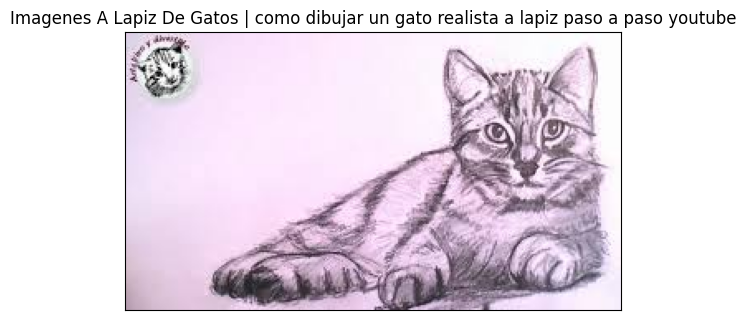

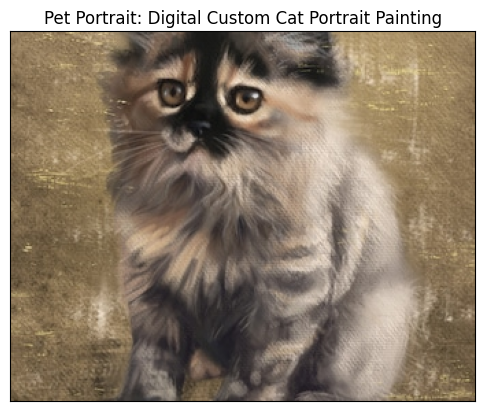

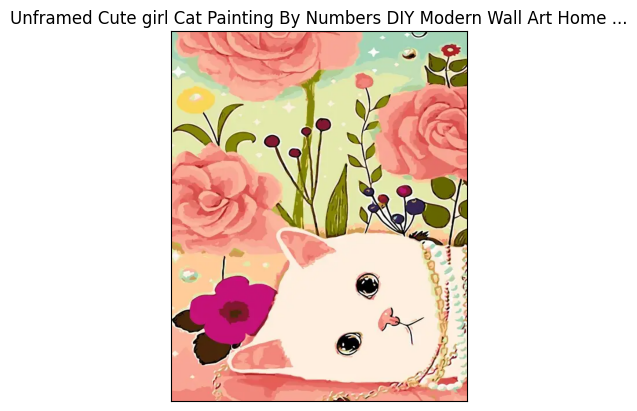

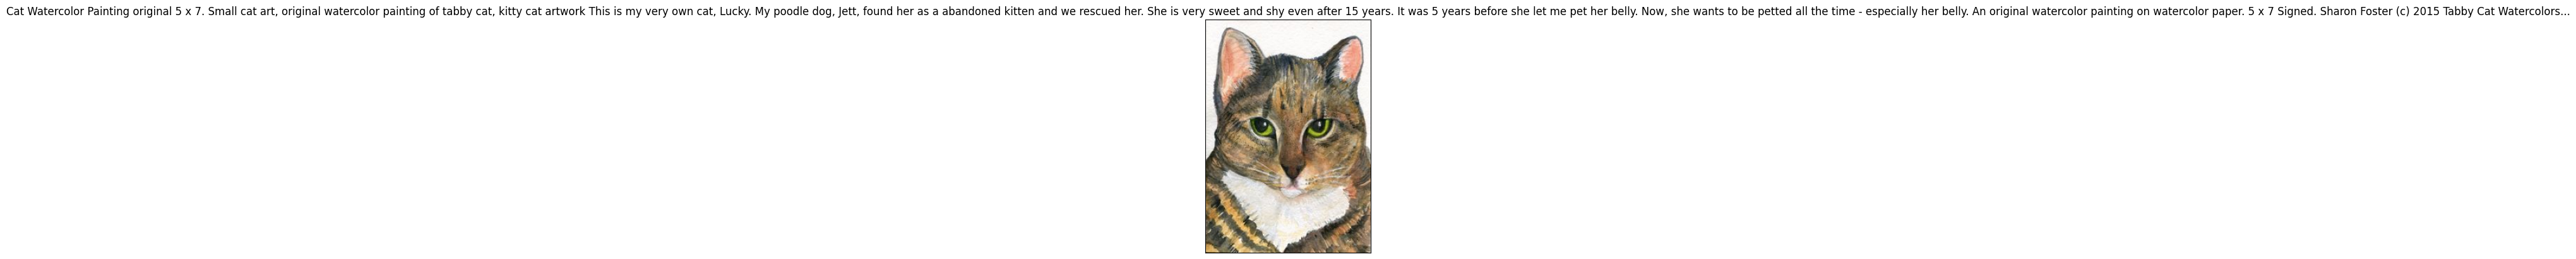

In [27]:
images = retrieve_images(prompt)

for i in range(len(images)):
    plt.imshow(images[i][0])
    plt.title(images[i][1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

# CLIP Visualization

In [26]:
def get_word_embeddings(prompt, tokenizer=tokenizer, text_encoder=text_encoder):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt").to("cuda")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids)[0].reshape(1,-1)   
    text_embeddings = text_embeddings.cpu().numpy()
    return text_embeddings/np.linalg.norm(text_embeddings)

In [27]:
def get_concat_embeddings(names):
    embeddings = []

    for name in names:
        embedding = get_word_embeddings(name)
        embeddings.append(embedding)

    embeddings = np.vstack(embeddings)
    return embeddings

In [28]:
def get_axis_embeddings(A, B):
    emb = []

    for a,b in zip(A,B):
        e = get_word_embeddings(a) - get_word_embeddings(b)
        emb.append(e)

    emb = np.vstack(emb)
    ax = np.average(emb, axis=0).reshape(1,-1)

    return ax

In [29]:
masculine = [
    "man",
    "king",
    "prince",
    "husband",
    "father",
]

feminine = [
    "woman",
    "queen",
    "princess",
    "wife",
    "mother",
]

In [30]:
young = [
    "man",
    "woman",
    "king",
    "queen",
    "father",
]

old = [
    "boy",
    "girl",
    "prince",
    "princess",
    "son",
]

In [31]:
common = [
    "man",
    "woman",
    "boy",
    "girl",
    "woman",
]

elite = [
    "king",
    "queen",
    "prince",
    "princess",
    "duchess",
]

In [32]:
singular = [
    "boy",
    "girl",
    "cat",
    "puppy",
    "computer",
]

plural = [
    "boys",
    "girls",
    "cats",
    "puppies",
    "computers",
]

In [33]:
axis_combinations = {
    "age": young + old,
    "gender": masculine + feminine,
    "royalty": common + elite,
    "number": singular + plural,
}

In [34]:
def calculate_residual(axis, axis_names, from_words=None, to_words=None):
    if axis_names[0] in axis_combinations:
        xembeddings = get_concat_embeddings(axis_combinations[axis_names[0]])
    else:
        xembeddings = get_concat_embeddings(from_words + to_words)

    if axis_names[2] in axis_combinations:
        zembeddings = get_concat_embeddings(axis_combinations[axis_names[2]])
    else:
        zembeddings = get_concat_embeddings(from_words + to_words)

    xprojections = xembeddings @ axis[0].T
    zprojections = zembeddings @ axis[2].T

    partial_residual = xembeddings - (xprojections.reshape(-1,1)*xembeddings)
    residual = partial_residual - (zprojections.reshape(-1,1)*zembeddings)

    residual = np.average(residual, axis=0).reshape(1,-1)
    residual = residual/np.linalg.norm(residual)

    return residual

In [35]:
age = get_axis_embeddings(young, old)
gender = get_axis_embeddings(masculine, feminine)
royalty = get_axis_embeddings(common, elite)

In [36]:
axis_names = ["gender", "residual", "age"]
examples = ["king", 
            "queen", 
            "man",
            "woman",
            "boy",
            "child",
            "apple",
            "orange",]

In [37]:
model_id = "segmind/tiny-sd"
adapter_id = "akameswa/lcm-lora-tiny-sd"

In [38]:
pipe = AutoPipelineForText2Image.from_pretrained(model_id)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "_name_or_path": "segmind/tiny-sd",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "LCMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [39]:
PeftModel.from_pretrained(pipe.unet, adapter_id)

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0): Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Conv2d(
                (base_layer): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Conv2d(320, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
               

In [81]:
images = []
for example in examples:
    image = pipe(prompt=example, num_inference_steps=4, guidance_scale=1.0).images[0]
    buffer = BytesIO()
    image.save(buffer, format='JPEG')
    encoded_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
    images.append("data:image/jpeg;base64, " + encoded_image)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [41]:
axis = np.vstack([gender, royalty, age])
axis[1] = calculate_residual(axis, axis_names)

In [42]:
coords = get_concat_embeddings(examples) @ axis.T
coords[:, 1] = 5*(1.0 - coords[:, 1])
print(coords)

[[ 0.06891518  0.6136799   0.05416381]
 [-0.09486384  0.6443986   0.05578901]
 [ 0.08701158  0.6955129   0.01985677]
 [-0.11131697  0.739764    0.06535601]
 [ 0.07099577  0.88644594 -0.07071026]
 [ 0.00815495  0.8472839  -0.03120728]
 [ 0.00533911  1.4197109  -0.02414933]
 [ 0.00589846  1.5043733  -0.02036477]]


In [43]:
def update_fig():
    global coords, examples, fig
    fig.data[0].x = coords[:,0]
    fig.data[0].y = coords[:,1]
    fig.data[0].z = coords[:,2]
    fig.data[0].text = examples
    
    return (f'''
            <script>
                document.getElementById("html").src += "?rand={random.random()}"
            </script>
            <iframe id="html" src="http://127.0.0.1:8000" style="width:100%; height:750px;"></iframe>
            ''')

In [44]:
def add_word(new_example):
    global coords, images, examples, fig
    new_coord = get_concat_embeddings([new_example]) @ axis.T
    new_coord[:, 1] = 5*(1.0 - new_coord[:, 1])

    coords = np.vstack([coords, new_coord])

    image = pipe(prompt=new_example, num_inference_steps=4, guidance_scale=1.0).images[0]
    buffer = BytesIO()
    image.save(buffer, format='JPEG')
    encoded_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
    images.append("data:image/jpeg;base64, " + encoded_image)

    examples.append(new_example)
    return update_fig()

In [45]:
def remove_word(new_example):
    global coords, images, examples, fig
    examplesMap = { example: index for index, example in enumerate(examples) }
    index = examplesMap[new_example]
    
    coords = np.delete(coords, index, 0)
    images.pop(index)
    examples.pop(index)
    
    return update_fig()

In [46]:
def add_rem_word(new_example):
    global examples
    if new_example in examples:
        return remove_word(new_example)
    else:
        return add_word(new_example)

In [47]:
axisMap = { "X - Axis": 0,
            "Y - Axis": 1,
            "Z - Axis": 2,
            }

In [85]:
def set_axis(axis_name, which_axis, from_words, to_words):
    global coords, examples, fig, axis_names

    if axis_name != "residual":
        from_words, to_words = from_words.split(), to_words.split()
        axis_emb = get_axis_embeddings(from_words, to_words)
        axis[axisMap[which_axis]] = axis_emb
        axis_names[axisMap[which_axis]] = axis_name

        for i, name in enumerate(axis_names):
            if name == "residual":
                axis[i] = calculate_residual(axis, axis_names, from_words, to_words)
                axis_names[i] = "residual"
    else:
        residual = calculate_residual(axis, axis_names, from_words, to_words)
        axis[axisMap[which_axis]] = residual
        axis_names[axisMap[which_axis]] = axis_name

    coords = get_concat_embeddings(examples) @ axis.T
    coords[:, 1] = 5*(1.0 - coords[:, 1])

    fig.update_layout(
        scene = dict(
            xaxis_title = axis_names[0],
            yaxis_title = axis_names[1],
            zaxis_title = axis_names[2],
        )
    )
    return update_fig()
    

In [49]:
def change_word(example):
    remove_word(example)
    add_word(example)
    return update_fig()

In [50]:
def clear_words():
    while examples:
        remove_word(examples[-1])
    return update_fig()

In [83]:
fig = px.scatter_3d(
                    x=coords[:,0], 
                    y=coords[:,1], 
                    z=coords[:,2], 
                    labels={
                            "x":axis_names[0],
                            "y":axis_names[1],
                            "z":axis_names[2],
                            },
                    text=examples,
                    height=750,
        )

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene_camera = dict(
        eye=dict(x=2, y=2, z=0.1)
    )
)

fig.update_traces(hoverinfo="none", hovertemplate=None)

app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="tooltip"),
    ],
)

@callback(
    Output("tooltip", "show"),
    Output("tooltip", "bbox"),
    Output("tooltip", "children"),
    Output("tooltip", "direction"),

    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update, no_update

    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    direction = "left"
    index = hover_data['pointNumber']
    
    children = [
        html.Img(
            src=images[index],
            style={"width": "150px"},
        ),
    ]

    return True, bbox, children, direction

# Demo

In [86]:
with gr.Blocks() as demo:
    gr.Markdown("## Stable Diffusion Demo")
    with gr.Tab("CLIP"):
        with gr.Row():
            output = gr.HTML(f'''
                    <iframe id="html" src="http://127.0.0.1:8000" style="width:100%; height:750px;"></iframe>
                    ''')
        with gr.Row():
            clear_words_button = gr.Button(value="Clear words")
        with gr.Row():
            word2add_rem = gr.Textbox(lines=2, label="Add/Remove word")
            word2change = gr.Textbox(lines=2, label="Change image for word")
        with gr.Row():
            add_rem_word_button = gr.Button(value="Add/Remove")
            change_word_button = gr.Button(value="Change")
        with gr.Accordion("Custom Semantic Dimensions", open=False):
            with gr.Accordion("Built-In Dimension 1"):
                with gr.Row():
                    axis_name_1 = gr.Textbox(label="Axis name", value="gender")
                    which_axis_1 = gr.Dropdown(choices=["X - Axis", "Y - Axis", "Z - Axis"], value="X - Axis", label="Axis direction")
                with gr.Row():
                    set_axis_button_1 = gr.Button(value="Submit")
                with gr.Accordion("Words", open=False):
                    with gr.Row():
                        from_words_1 = gr.Textbox(lines=10, label="", value=f"""prince
husband
father
son
uncle""")
                        to_words_1 = gr.Textbox(lines=10, label="", value=f"""princess
wife
mother
daughter
aunt""")
            with gr.Accordion("Built-In Dimension 2"):
                with gr.Row():
                    axis_name_2 = gr.Textbox(label="Axis name", value="number")
                    which_axis_2 = gr.Dropdown(choices=["X - Axis", "Y - Axis", "Z - Axis"], value="Z - Axis", label="Axis direction")
                with gr.Row():
                    set_axis_button_2 = gr.Button(value="Submit")
                with gr.Accordion("Words", open=False):
                    with gr.Row():
                        from_words_2 = gr.Textbox(lines=10, label="", value=f"""boys
girls
cats
puppies
computers""")
                        to_words_2 = gr.Textbox(lines=10, label="", value=f"""boy
girl
cat
puppy
computer""")
            with gr.Accordion("Built-In Dimension 3"):
                with gr.Row():
                    axis_name_3 = gr.Textbox(label="Axis name", value="age")
                    which_axis_3 = gr.Dropdown(choices=["X - Axis", "Y - Axis", "Z - Axis"], label="Axis direction")
                with gr.Row():
                    set_axis_button_3 = gr.Button(value="Submit")
                with gr.Accordion("Words", open=False):
                    with gr.Row():
                        from_words_3 = gr.Textbox(lines=10, label="", value=f"""man
woman
king
queen
father""")
                        to_words_3 = gr.Textbox(lines=10, label="", value=f"""boy
girl
prince
princess
son""")
            with gr.Accordion("Built-In Dimension 4"):
                with gr.Row():
                    axis_name_4 = gr.Textbox(label="Axis name", value="royalty")
                    which_axis_4 = gr.Dropdown(choices=["X - Axis", "Y - Axis", "Z - Axis"], label="Axis direction")
                with gr.Row():
                    set_axis_button_4 = gr.Button(value="Submit")
                with gr.Accordion("Words", open=False):
                    with gr.Row():
                        from_words_4 = gr.Textbox(lines=10, label="", value=f"""king
queen
prince
princess
woman""")
                        to_words_4 = gr.Textbox(lines=10, label="", value=f"""man
woman
boy
girl
duchess""")
            with gr.Accordion("Built-In Dimension 5"):
                with gr.Row():
                    axis_name_5 = gr.Textbox(label="Axis name", value="")
                    which_axis_5 = gr.Dropdown(choices=["X - Axis", "Y - Axis", "Z - Axis"], label="Axis direction")
                with gr.Row():
                    set_axis_button_5 = gr.Button(value="Submit")
                with gr.Accordion("Words", open=False):
                    with gr.Row():
                        from_words_5 = gr.Textbox(lines=10, label="")
                        to_words_5 = gr.Textbox(lines=10, label="")

    
    add_rem_word_button.click(fn=add_rem_word, inputs=[word2add_rem], outputs=[output])
    change_word_button.click(fn=change_word, inputs=[word2change], outputs=[output])
    clear_words_button.click(fn=clear_words, outputs=[output])
    
    set_axis_button_1.click(fn=set_axis, inputs=[axis_name_1, which_axis_1, from_words_1, to_words_1], outputs=[output])
    set_axis_button_2.click(fn=set_axis, inputs=[axis_name_2, which_axis_2, from_words_2, to_words_2], outputs=[output])
    set_axis_button_3.click(fn=set_axis, inputs=[axis_name_3, which_axis_3, from_words_3, to_words_3], outputs=[output])
    set_axis_button_4.click(fn=set_axis, inputs=[axis_name_4, which_axis_4, from_words_4, to_words_4], outputs=[output])
    set_axis_button_5.click(fn=set_axis, inputs=[axis_name_5, which_axis_5, from_words_5, to_words_5], outputs=[output])

    with gr.Tab("Animation"):
        with gr.Row():
            with gr.Column():
                prompt_anim = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_inference_steps_anim = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Inference Steps per Image")
                seed_anim = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_anim = gr.Button("Generate Images")
            
            with gr.Column():
                images_output_anim = gr.Gallery(label="Images", selected_index=0)
    
    @generate_images_button_anim.click(inputs=[prompt_anim, seed_anim, num_inference_steps_anim], outputs=[images_output_anim])
    def generate_images_wrapper(prompt, seed, num_inference_steps):
        images, _ = display_images(prompt, seed, num_inference_steps, poke=False, intermediate=True)
        return images
    
    with gr.Tab("Seed"):
        with gr.Row():
            with gr.Column():
                prompt_seed = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_images_seed = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                num_inference_steps_seed = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                generate_images_button_seed = gr.Button("Generate Images")
            
            with gr.Column():
                images_output_seed = gr.Gallery(label="Images", selected_index=0)

    with gr.Tab("Spread"):
        with gr.Row():
            with gr.Column():
                prompt_spread = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_images_spread = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                differentiation_spread = gr.Slider(minimum=0, maximum=1, step=0.1, value=0.1, label="Differentiation", info="The higher the differentiation, the more different the images will be")
                num_inference_steps_spread = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                seed_spread = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_spread = gr.Button("Generate Images")

            with gr.Column():
                images_output_spread = gr.Gallery(label="Image", selected_index=0)    

    with gr.Tab("Circular"):
        with gr.Row():
            with gr.Column():
                prompt_circular = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_images_circular = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                differentiation_circular = gr.Slider(minimum=0, maximum=1, step=0.1, value=0.1, label="Differentiation", info="The higher the differentiation, the more different the images will be")
                num_inference_steps_circular = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                seed_circular = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_circular = gr.Button("Generate Images")

            with gr.Column():
                images_output_circular = gr.Gallery(label="Image", selected_index=0)    

    with gr.Tab("Interpolate"):
        with gr.Row():
            with gr.Column():
                promptA = gr.Textbox(lines=1, label="Prompt from", value="car driving on a highway in a city")
                num_images_1 = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                num_inference_steps_1 = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                seed_1 = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                
            with gr.Column():
                promptB = gr.Textbox(lines=1, label="Prompt to", value="truck driving on a highway in a city")                
        
        with gr.Row():
            generate_images_button_1 = gr.Button("Generate Images")

        with gr.Row():
            images_output_1 = gr.Gallery(label="Interpolated Images", selected_index=0)
    
    with gr.Tab("Poke"):
        with gr.Row():
            with gr.Column():
                pokeX = gr.Slider(label="pokeX", minimum=0, maximum=imageWidth, step=1, value=256, info= "X coordinate of poke center")
                pokeY = gr.Slider(label="pokeY", minimum=0, maximum=imageHeight, step=1, value=256, info= "Y coordinate of poke center")
                pokeHeight = gr.Slider(label="pokeHeight", minimum=0, maximum=imageHeight, step=8, value=128, info= "Height of the poke")
                pokeWidth = gr.Slider(label="pokeWidth", minimum=0, maximum=imageWidth, step=8, value=128, info= "Width of the poke")
                visualize_poke_button = gr.Button("Visualize Poke")

            with gr.Column():
                visualize_poke_output = gr.Image(label="Poke Visualization")
                    
        with gr.Row():
            with gr.Column():
                prompt_0 = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_inference_steps_0 = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Inference Steps per Image")
                seed_0 = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_0 = gr.Button("Generate Images")
            
            with gr.Column():
                original_images_output_0 = gr.Gallery(label="Original Images", selected_index=0)
                poked_images_output_0 = gr.Gallery(label="Poked Images", selected_index=0)

    # with gr.Tab("Dataset Peek"):
    #     with gr.Row():
    #         with gr.Column():
    #             prompt_3 = gr.Textbox(lines=1, label="Prompt", value="dog")
    #             retrieve_images_button = gr.Button("Retrieve Images")
    #             retrieved_images_output = gr.Gallery(label="Image", selected_index=0)
                
    generate_images_button_seed.click(fn=display_seed_images, inputs=[prompt_seed, num_inference_steps_seed, num_images_seed], outputs=[images_output_seed])
    generate_images_button_spread.click(fn=display_spread_images, inputs=[prompt_spread, seed_spread, num_inference_steps_spread, num_images_spread, differentiation_spread], outputs=images_output_spread)
    generate_images_button_circular.click(fn=display_circular_images, inputs=[prompt_circular, seed_circular, num_inference_steps_circular, num_images_circular, differentiation_circular], outputs=images_output_circular)
    visualize_poke_button.click(fn=visualize_poke, inputs=[pokeX, pokeY, pokeHeight, pokeWidth], outputs=visualize_poke_output)

    @generate_images_button_0.click(inputs=[prompt_0, pokeX, pokeY, pokeHeight, pokeWidth, seed_0, num_inference_steps_0], outputs=[original_images_output_0, poked_images_output_0])
    def generate_images_wrapper(prompt, pokeX, pokeY, pokeHeight, pokeWidth, seed, num_inference_steps):
        images, modImages = display_images(prompt, seed, num_inference_steps, poke=True, pokeX=pokeX, pokeY=pokeY, pokeHeight=pokeHeight, pokeWidth=pokeWidth, intermediate=True)
        return images, modImages
    
    generate_images_button_1.click(fn=display_prompt_images, inputs=[seed_1, promptA, promptB, num_inference_steps_1, num_images_1], outputs=images_output_1)
    # retrieve_images_button.click(fn=retrieve_images, inputs=[prompt_3], outputs=retrieved_images_output)
    
if __name__ == "__main__":
    demo.queue()
    app.run(host="127.0.0.1", port="8000")
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://6367b92c77e05fa020.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
